In [3]:
import time

import tqdm.notebook
# import time
%load_ext autoreload
%autoreload 2
# # %load_ext rich

In [1]:
import requests
import os
os.getcwd()
os.chdir('/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground')
# %reload_ext autoreload
import allib
from allib.models.al import get_al_strategy
import importlib
import pandas as pd
import numpy as np

# importlib.reload(allib)

## Heart Disease

In [2]:
# DB = allib.datasets.get_uci_db()
# dataset = DB["heart-disease"]
# import requests
# URL_TEMPLATE = "https://archive.ics.uci.edu/static/public/%s/%s.zip"
# url = URL_TEMPLATE % (dataset["ID"], dataset["slug"])


In [12]:
ds = allib.datasets.load_uci("heart-disease")

# find missing values
ds.with_preprocess(
    steps=[
        "sample_n", 
        "categorical_only",
        # "remove_constant_columns", 
        # "drop_duplicate_rows"
    ],  
    params_list=[
        {"n": 1000, "random_state": 0},
        # {"encode": encode}, 
        {}, 
        # {}
    ], 
    in_place=True
)
# df[df["ca"] == "?"]
# all(df.iloc[166] != "?")
# df_processed = df[df.apply(lambda row: all(row != "?"), axis=1)]
# len(df_processed), len(df)

In [21]:
ds._data

,sex,cp,fbs,restecg,exang,slope,thal
0,1.0,1.0,0.0,2.0,0.0,2.0,6.0
1,0.0,4.0,0.0,2.0,0.0,2.0,3.0
2,1.0,3.0,1.0,2.0,1.0,2.0,6.0
3,1.0,4.0,0.0,2.0,0.0,1.0,3.0
4,1.0,2.0,0.0,0.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...
292,1.0,4.0,0.0,0.0,0.0,2.0,3.0
293,1.0,4.0,0.0,2.0,1.0,2.0,3.0
294,1.0,4.0,1.0,2.0,1.0,1.0,7.0
295,1.0,4.0,0.0,2.0,0.0,2.0,7.0


In [15]:
def _get_feature_info(info: dict, dataset_name: str):
    columns = []
    cat_idx = []
    for idx, attr in enumerate(info[dataset_name]["attributes"]):
        a = attr["name"].strip().lower().replace("-", "_").replace(" ", "_")
        columns.append(a)
        if attr["type"] in ["Categorical", "Binary"] and attr["role"] != "Target":
            cat_idx.append(idx)
    return columns, cat_idx

In [3]:
uci_db = allib.datasets.get_uci_db()
print(len(uci_db.keys()))

614


In [5]:
# get attributes from datasets
print(f"total attributes: {len(uci_db['iris']['attributes'])}")
columns = []
for a in uci_db['iris']['attributes']:
    # handle name
    columns.append(a["name"].strip().lower().replace(" ", "_"))

total attributes: 5


In [6]:
d1 = pd.read_csv(os.path.join(allib.CACHE_DIR, "iris/iris.data"), skiprows=0, names=columns)
d2 = pd.read_csv(os.path.join(allib.CACHE_DIR, "iris/bezdekIris.data"), skiprows=0, names=columns)

In [8]:
d1["class"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [9]:
d2["class"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
data = pd.concat((d1, d2)).reset_index(drop=True)
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,300.000000,300.000000,300.000000,300.000000
mean,5.843333,3.055667,3.758333,1.199000
std,0.826680,0.434007,1.761906,0.761423
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<Axes: >

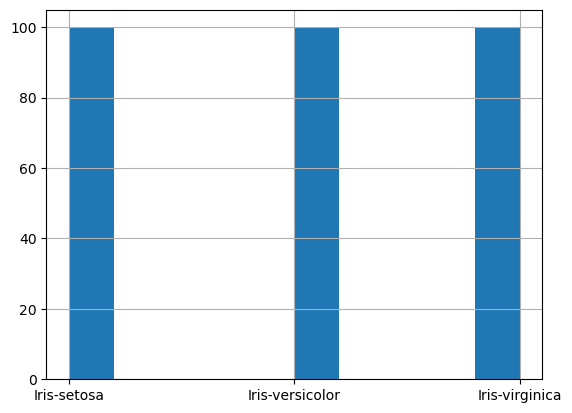

In [46]:
data["class"].hist()

In [47]:
# shuffle the dataset
from sklearn.utils import shuffle

data: pd.DataFrame = shuffle(data, random_state=42)
data.reset_index(drop=True)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.5,2.3,4.0,1.3,Iris-versicolor
1,6.5,3.0,5.5,1.8,Iris-virginica
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.9,3.1,1.5,0.1,Iris-setosa
4,6.0,2.7,5.1,1.6,Iris-versicolor
...,...,...,...,...,...
295,4.4,3.0,1.3,0.2,Iris-setosa
296,6.1,2.8,4.0,1.3,Iris-versicolor
297,4.9,2.5,4.5,1.7,Iris-virginica
298,6.9,3.2,5.7,2.3,Iris-virginica


## Yeast

In [5]:
yeast_dataset = allib.datasets.load_uci("yeast")

In [10]:
# get attributes from datasets
print(f"total attributes: {len(uci_db['yeast']['attributes'])}")
columns = []
for a in uci_db['yeast']['attributes']:
    # handle name
    columns.append(a["name"].strip().lower().replace(" ", "_"))
columns

total attributes: 10


['sequence_name',
 'mcg',
 'gvh',
 'alm',
 'mit',
 'erl',
 'pox',
 'vac',
 'nuc',
 'localization_site']

In [11]:
raw_data = pd.read_csv("dataset_cache/yeast/yeast.data", delim_whitespace=True, names=columns)

In [17]:
label = raw_data.localization_site
data = raw_data.drop(columns=["sequence_name", "localization_site"])

## Letter Recognition

In [2]:
letter_dataset = allib.datasets.load_uci("letter-recognition")

In [6]:
# get attributes from datasets
print(f"total attributes: {len(uci_db['letter-recognition']['attributes'])}")
columns = []
for a in uci_db['letter-recognition']['attributes']:
    # handle name
    columns.append(a["name"].strip().lower().replace("-", "_"))
columns

total attributes: 17


['lettr',
 'x_box',
 'y_box',
 'width',
 'high',
 'onpix',
 'x_bar',
 'y_bar',
 'x2bar',
 'y2bar',
 'xybar',
 'x2ybr',
 'xy2br',
 'x_ege',
 'xegvy',
 'y_ege',
 'yegvx']

In [7]:
raw_data = pd.read_csv("dataset_cache/letter-recognition/letter-recognition.data", names=columns)

In [8]:
data = raw_data.rename(columns={"lettr": "label"})
label = data.label.apply(str.strip)
data = raw_data.drop(columns=["lettr"])
data

,x_box,y_box,width,high,onpix,x_bar,y_bar,x2bar,y2bar,xybar,x2ybr,xy2br,x_ege,xegvy,y_ege,yegvx
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


## Image Segmentation

In [2]:
img_dataset = allib.datasets.load_uci("image-segmentation")

In [13]:
# get attributes from datasets
print(f"total attributes: {len(uci_db['image-segmentation']['attributes'])}")
columns = []
for a in uci_db['image-segmentation']['attributes']:
    # handle name
    columns.append(a["name"].strip().lower().replace("-", "_"))
columns

total attributes: 20


['class',
 'region_centroid_col',
 'region_centroi_row',
 'region_pixel_count',
 'short_line_density_5',
 'short_line_density_2',
 'vedge_mean',
 'vedge_sd',
 'hedge_mean',
 'hedge_sd',
 'intensity_mean',
 'rawred_mean',
 'rawblue_mean',
 'rawgreen_mean',
 'exred_mean',
 'exblue_mean',
 'exgreen_mean',
 'value_mean',
 'saturation_mean',
 'hue_mean']

In [22]:
d1 = pd.read_csv("dataset_cache/image-segmentation/segmentation.test", skiprows=5, names=columns)
data = d1.rename(columns={"class": "label"})
label = data.label.apply(str.strip)
data = data.drop(columns=["label"])
data

,region_centroid_col,region_centroi_row,region_pixel_count,short_line_density_5,short_line_density_2,vedge_mean,vedge_sd,hedge_mean,hedge_sd,intensity_mean,rawred_mean,rawblue_mean,rawgreen_mean,exred_mean,exblue_mean,exgreen_mean,value_mean,saturation_mean,hue_mean
0,110.0,189.0,9,0.000000,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,86.0,187.0,9,0.000000,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,225.0,244.0,9,0.000000,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
3,47.0,232.0,9,0.000000,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
4,97.0,186.0,9,0.000000,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,32.0,158.0,9,0.000000,0.0,0.944445,0.862963,0.833333,0.611111,7.962963,6.333334,11.888889,5.666666,-4.888889,11.777778,-6.888889,11.888889,0.520578,-1.982834
2096,8.0,162.0,9,0.111111,0.0,1.611111,2.062962,0.333333,0.133333,8.370370,6.666666,12.000000,6.444445,-5.111111,10.888889,-5.777778,12.000000,0.484805,-2.044946
2097,128.0,161.0,9,0.000000,0.0,0.555555,0.251852,0.777778,0.162963,7.148148,5.555555,10.888889,5.000000,-4.777778,11.222222,-6.444445,10.888889,0.540918,-1.996307
2098,150.0,158.0,9,0.000000,0.0,2.166667,1.633334,1.388889,0.418518,8.444445,7.000000,12.222222,6.111111,-4.333334,11.333333,-7.000000,12.222222,0.503086,-1.943449


In [20]:
d = pd.read_csv("dataset_cache/image-segmentation/segmentation.data", skiprows=5, names=columns)
data = d.rename(columns={"class": "label"})
label = data.label.apply(str.strip)
data = data.drop(columns=["label"])
data

,region_centroid_col,region_centroi_row,region_pixel_count,short_line_density_5,short_line_density_2,vedge_mean,vedge_sd,hedge_mean,hedge_sd,intensity_mean,rawred_mean,rawblue_mean,rawgreen_mean,exred_mean,exblue_mean,exgreen_mean,value_mean,saturation_mean,hue_mean
0,140.0,125.0,9,0.000000,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,188.0,133.0,9,0.000000,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,105.0,139.0,9,0.000000,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,34.0,137.0,9,0.000000,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,39.0,111.0,9,0.000000,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,36.0,243.0,9,0.111111,0.0,1.888889,1.851851,2.000000,0.711110,13.333333,9.888889,12.111111,18.000000,-10.333333,-3.666667,14.000000,18.000000,0.452229,2.368311
206,186.0,218.0,9,0.000000,0.0,1.166667,0.744444,1.166667,0.655555,13.703704,10.666667,12.666667,17.777779,-9.111111,-3.111111,12.222222,17.777779,0.401347,2.382684
207,197.0,236.0,9,0.000000,0.0,2.444444,6.829628,3.333333,7.599998,16.074074,13.111111,16.666668,18.444445,-8.888889,1.777778,7.111111,18.555555,0.292729,2.789800
208,208.0,240.0,9,0.111111,0.0,1.055556,0.862963,2.444444,5.007407,14.148149,10.888889,13.000000,18.555555,-9.777778,-3.444444,13.222222,18.555555,0.421621,2.392487


## Balance Scale

In [4]:
bs_dataset = allib.datasets.load_uci("balance-scale")

Dataset balance-scale downloaded, but it need to be manually processed


Temp file downloaded: C:\Users\MJ_OL\AppData\Local\Temp\tmppyubnw6y
Extracting C:\Users\MJ_OL\AppData\Local\Temp\tmppyubnw6y to E:\Courses\COMP8800\Projects\CatBoostPlayground\examples\dataset_cache\balance-scale...


In [ ]:
columns, cat_idx = _get_feature_info(uci_db, "balance-scale")
d = pd.read_csv("dataset_cache/balance-scale/balance-scale.data", skiprows=0, names=columns)
data = d.rename(columns={"class_name": "label"})
label = data.label
data = data.drop(columns=["label"])
data,label

## Glass Identification

In [24]:
gi_dataset = allib.datasets.load_uci("glass-identification")

Dataset glass-identification downloaded, but it need to be manually processed


Temp file downloaded: C:\Users\MJ_OL\AppData\Local\Temp\tmpq9r540gi
Extracting C:\Users\MJ_OL\AppData\Local\Temp\tmpq9r540gi to E:\Courses\COMP8800\Projects\CatBoostPlayground\examples\dataset_cache\glass-identification...


In [ ]:
columns, cat_idx = _get_feature_info(uci_db, "glass-identification")
d = pd.read_csv("dataset_cache/glass-identification/glass.data", skiprows=0, names=columns)
data = d.rename(columns={"type_of_glass": "label"})
label = data.label
data = data.drop(columns=["id_number", "label"])
data,label

## Wine

In [35]:
name = "wine"
wine_dataset = allib.datasets.load_uci(name)

Dataset wine downloaded, but it need to be manually processed


Temp file downloaded: C:\Users\MJ_OL\AppData\Local\Temp\tmpf73t_6ru
Extracting C:\Users\MJ_OL\AppData\Local\Temp\tmpf73t_6ru to E:\Courses\COMP8800\Projects\CatBoostPlayground\examples\dataset_cache\wine...


"<class 'allib.models.al.al_strategies.UncertainStrategy'>"

In [38]:
columns, cat_idx = _get_feature_info(uci_db, "wine")
d = pd.read_csv("dataset_cache/wine/wine.data", skiprows=0, names=columns)
data = d.rename(columns={"class": "label"})
label = data.label
data = data.drop(columns=["label"])
data

,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0d280_0d315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [5]:
params = {
    "init_size": 30,
    "batch_size": 20,
    "random_state": 0
}

_svm_md = allib.models.get_pipeline("svm")
_lr_md = allib.models.get_pipeline("logistic")
_c_md = allib.models.get_pipeline("catboost")
ds = img_dataset.with_metric(get_al_metric(name="uncertain", params=params))
svm_md = _svm_md(model=None, eval_metrics=allib.metrics.get_metrics(["accuracy"]), seeds=[0], dataset=ds, early_stop=10, **params)
c_md = _c_md(model=None, eval_metrics=allib.metrics.get_metrics(["accuracy"]), seeds=[0], dataset=ds, early_stop=10, **params)
lr_md = _c_md(model=None, eval_metrics=allib.metrics.get_metrics(["accuracy"]), seeds=[0], dataset=ds, early_stop=10, **params)

In [6]:
ds.reset()
svm_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [8]:
ds.reset()
c_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
ds.reset()
lr_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
c_md.stats[0]["accuracy"]

[0.3477088948787062,
 0.431266846361186,
 0.4636118598382749,
 0.5067385444743935,
 0.431266846361186,
 0.46900269541778977,
 0.46900269541778977,
 0.5121293800539084,
 0.49865229110512127,
 0.5579514824797843]

In [7]:
svm_md.stats[0]["accuracy"]

[0.6415094339622641,
 0.6226415094339622,
 0.6415094339622641,
 0.6981132075471698,
 0.7547169811320755,
 0.7358490566037735,
 0.7358490566037735,
 0.7358490566037735]

In [14]:
lr_md.stats[0]["accuracy"]

[0.3477088948787062,
 0.431266846361186,
 0.4636118598382749,
 0.5067385444743935,
 0.431266846361186,
 0.46900269541778977,
 0.46900269541778977,
 0.5121293800539084,
 0.49865229110512127,
 0.5579514824797843]

In [8]:
# split training/testing
from sklearn.model_selection import train_test_split

data = data.rename(columns={"class": "label"})
label = data.label
data = data.drop(columns=["label"])

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, random_state=42)

In [40]:
import catboost
from catboost import CatBoostClassifier, sum_models, to_classifier
from catboost.utils import create_cd

In [58]:
# sample the initial datasets

X_init = X_train.sample(n=10)
Y_init = Y_train.loc[X_init.index]
X_train = X_train.drop(X_init.index)
Y_train = Y_train.drop(Y_init.index)

In [52]:
BATCH_SIZE = 20
accuracy_unc = []
instances = []
cur_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
cur_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
models = [cur_model]
accuracy_unc.append(cur_model.score(X_test, Y_test))
instances.append(len(X_init))
while len(X_train) > 0:
    new_model = CatBoostClassifier(
        iterations=5,
        learning_rate=0.1,
        # loss_function='CrossEntropy'
    )

    if len(X_train) > BATCH_SIZE:
        # bottom BATCH_SIZE at score
        idx = cur_model.predict_proba(X_train).max(axis=1).argpartition(BATCH_SIZE)[:BATCH_SIZE]
        X_init = pd.concat((X_init, X_train.loc[X_train.index[idx]]))
        Y_init = pd.concat((Y_init, Y_train.loc[Y_train.index[idx]]))
        X_train = X_train.drop(X_train.index[idx])
        Y_train = Y_train.drop(Y_train.index[idx])
    else:
        X_init = pd.concat((X_init, X_train))
        Y_init = pd.concat((Y_init, Y_train))
        X_train = X_train.drop(X_train.index)
        Y_train = Y_train.drop(Y_train.index)
    new_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
    models.append(new_model)
    # todo: test merge strategy
    cur_model = to_classifier(sum_models(models, weights=[1.0 / len(models)] * len(models)))
    accuracy_unc.append(cur_model.score(X_test, Y_test))
    instances.append(len(X_init))

In [53]:
accuracy_unc

[0.8933333333333333,
 0.92,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96]

In [59]:
BATCH_SIZE = 20
accuracy_rand = []
instances = []
cur_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
cur_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
models = [cur_model]
accuracy_rand.append(cur_model.score(X_test, Y_test))
instances.append(len(X_init))
while len(X_train) > 0:
    new_model = CatBoostClassifier(
        iterations=5,
        learning_rate=0.1,
        # loss_function='CrossEntropy'
    )
    l = min(BATCH_SIZE, len(X_train))
    X_new = X_train.sample(n=l)
    Y_new = Y_train.loc[X_new.index]
    X_train = X_train.drop(X_new.index)
    Y_train = Y_train.drop(Y_new.index)
    X_init = pd.concat((X_init, X_new))
    Y_init = pd.concat((Y_init, Y_new))
    new_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
    models.append(new_model)
    # todo: test merge strategy
    cur_model = to_classifier(sum_models(models, weights=[1.0 / len(models)] * len(models)))
    accuracy_rand.append(cur_model.score(X_test, Y_test))
    instances.append(len(X_init))

In [4]:
accuracy_rand

total attributes: 15
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [26]:
idx = pred.max(axis=1).argpartition(-10)[-10:]

total attributes: 15
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
[1, 3, 5, 6, 7, 8, 9, 13, 14]
